# PCA with Random Forest

## bSMOTE borderline 1

In [1]:
# import packages and read csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_csv('DTI_with_group.csv')
df

,IMAGEUID,COLPROT,RID,VISCODE,VISCODE2,EXAMDATE,VERSION,MANUFACTURER,VOLUMES,RUNDATE,...,RD_UNC,RD_TAP,RD_IC,RD_CC,RD_CR,RD_FULLWM,update_stamp,Sex,Research Group,Age
0,957753,ADNI3,21,init,m144,1/25/18,2.0,Siemens,55,12/1/21,...,0.000600,0.001139,0.000491,0.000562,0.000638,0.000571,NaN,F,CN,84.9
1,987377,ADNI3,31,init,m150,4/17/18,NaN,Siemens,127,12/1/21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,CN,90.3
2,1158142,ADNI3,31,y1,m162,4/24/19,2.0,Siemens,127,12/1/21,...,0.000717,0.001507,0.000626,0.000701,0.000851,0.000723,NaN,F,CN,91.3
3,1116459,ADNI3,56,y1,m156,1/10/19,2.0,Siemens,127,12/1/21,...,0.000553,0.000950,0.000448,0.000512,0.000587,0.000531,NaN,F,CN,82.8
4,1189755,ADNI3,56,init,m144,11/28/17,2.0,Siemens,127,12/1/21,...,0.000530,0.000862,0.000437,0.000509,0.000573,0.000522,NaN,F,CN,81.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,1223044,ADNI3,6796,sc,sc,9/3/19,2.0,Siemens,127,12/1/21,...,0.000599,0.001623,0.000538,0.000680,0.000744,0.000652,NaN,M,AD,71.8
964,1220934,ADNI3,6797,sc,sc,8/28/19,2.0,Siemens,127,12/1/21,...,0.000619,0.000878,0.000487,0.000567,0.000618,0.000571,NaN,F,CN,67.2
965,1231994,ADNI3,6820,sc,sc,9/25/19,2.0,Siemens,127,12/1/21,...,0.000534,0.001478,0.000440,0.000694,0.000659,0.000597,NaN,M,AD,68.3
966,1236103,ADNI3,6822,sc,sc,10/3/19,2.0,Siemens,127,12/1/21,...,0.000566,0.000729,0.000441,0.000469,0.000534,0.000509,NaN,F,CN,61.7


In [2]:
# remove unnecessary columns and confounding variables
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
df = df.dropna()

df.head(5)

,AD_MCP,AD_PCT,AD_GCC,AD_BCC,AD_SCC,AD_FX,AD_CST_R,AD_CST_L,AD_ML_R,AD_ML_L,...,RD_FXST,RD_SLF,RD_SFO,RD_UNC,RD_TAP,RD_IC,RD_CC,RD_CR,RD_FULLWM,Research Group
0,0.001177,0.000974,0.001479,0.001474,0.001575,0.002257,0.001079,0.001081,0.001285,0.001287,...,0.000662,0.000577,0.000551,0.000600,0.001139,0.000491,0.000562,0.000638,0.000571,CN
2,0.001213,0.001075,0.001567,0.001585,0.001686,0.002492,0.001046,0.001056,0.001149,0.001126,...,0.000769,0.000694,0.000902,0.000717,0.001507,0.000626,0.000701,0.000851,0.000723,CN
3,0.001101,0.000965,0.001440,0.001433,0.001456,0.002379,0.000985,0.000990,0.001118,0.001113,...,0.000614,0.000546,0.000562,0.000553,0.000950,0.000448,0.000512,0.000587,0.000531,CN
4,0.001053,0.000904,0.001433,0.001470,0.001450,0.002421,0.000966,0.000977,0.001047,0.001041,...,0.000607,0.000535,0.000551,0.000530,0.000862,0.000437,0.000509,0.000573,0.000522,CN
5,0.001131,0.000974,0.001469,0.001498,0.001531,0.002291,0.000994,0.001017,0.001128,0.001105,...,0.000621,0.000559,0.000586,0.000558,0.000901,0.000458,0.000527,0.000605,0.000545,CN


In [3]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE as bSMOTE
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3',
                         'principal component 4', 'principal component 5', 'principal component 6', 
                         'principal component 7', 'principal component 8', 'principal component 9',
                         'principal component 10', 'principal component 11', 'principal component 12', 
                         'principal component 13', 'principal component 14', 'principal component 15', 
                         'principal component 16', 'principal component 17', 'principal component 18', 
                         'principal component 19', 'principal component 20'])

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 8)

In [6]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 88, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [7]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [8]:
clf.score(X_test, y_test)

0.921025641025641

In [9]:
print(confusion_matrix(y_test, pred))

[[145   0   0   1   4   0]
 [  4 120   8   2  20   6]
 [  0   4 150   0   3   0]
 [  0   0   1 164   2   0]
 [  1  16   2   1 151   0]
 [  1   0   0   0   1 168]]


In [10]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.96      0.97      0.96       150
          CN       0.86      0.75      0.80       160
        EMCI       0.93      0.96      0.94       157
        LMCI       0.98      0.98      0.98       167
         MCI       0.83      0.88      0.86       171
         SMC       0.97      0.99      0.98       170

    accuracy                           0.92       975
   macro avg       0.92      0.92      0.92       975
weighted avg       0.92      0.92      0.92       975



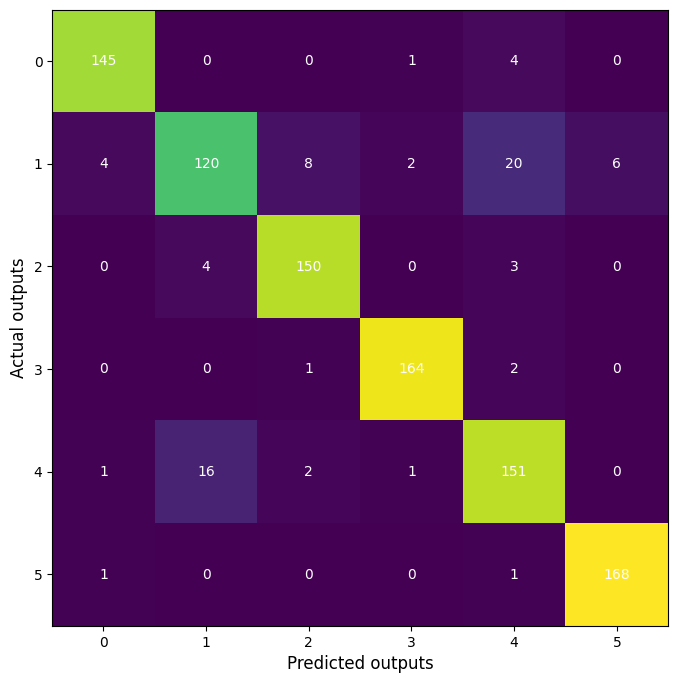

In [11]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

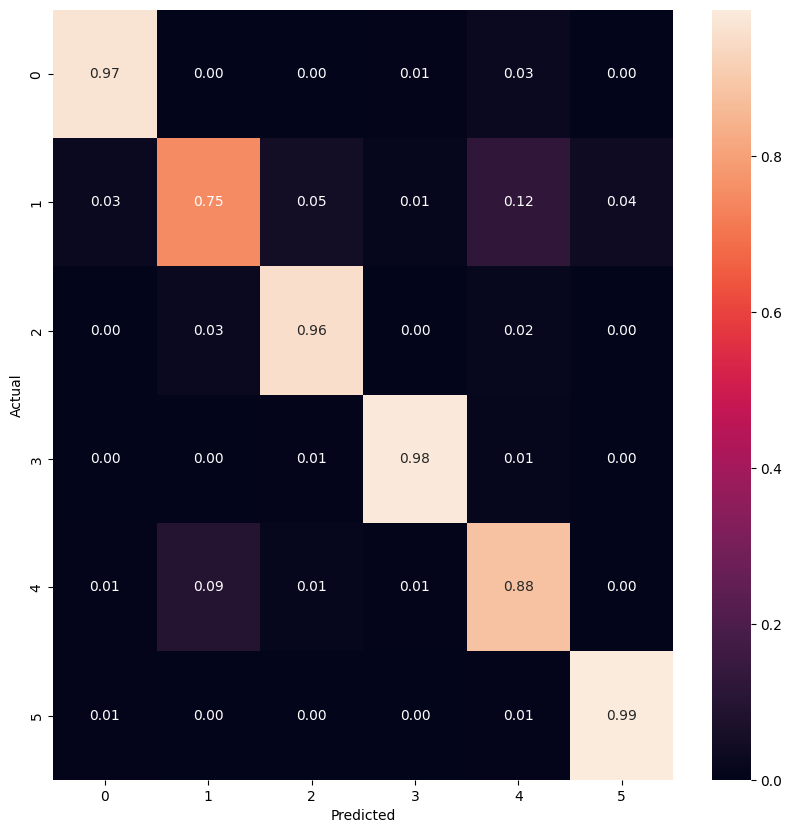

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [13]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
df = df.dropna()

df.head(5)

,AD_MCP,AD_PCT,AD_GCC,AD_BCC,AD_SCC,AD_FX,AD_CST_R,AD_CST_L,AD_ML_R,AD_ML_L,...,RD_FXST,RD_SLF,RD_SFO,RD_UNC,RD_TAP,RD_IC,RD_CC,RD_CR,RD_FULLWM,Research Group
0,0.001177,0.000974,0.001479,0.001474,0.001575,0.002257,0.001079,0.001081,0.001285,0.001287,...,0.000662,0.000577,0.000551,0.000600,0.001139,0.000491,0.000562,0.000638,0.000571,CN
2,0.001213,0.001075,0.001567,0.001585,0.001686,0.002492,0.001046,0.001056,0.001149,0.001126,...,0.000769,0.000694,0.000902,0.000717,0.001507,0.000626,0.000701,0.000851,0.000723,CN
3,0.001101,0.000965,0.001440,0.001433,0.001456,0.002379,0.000985,0.000990,0.001118,0.001113,...,0.000614,0.000546,0.000562,0.000553,0.000950,0.000448,0.000512,0.000587,0.000531,CN
4,0.001053,0.000904,0.001433,0.001470,0.001450,0.002421,0.000966,0.000977,0.001047,0.001041,...,0.000607,0.000535,0.000551,0.000530,0.000862,0.000437,0.000509,0.000573,0.000522,CN
5,0.001131,0.000974,0.001469,0.001498,0.001531,0.002291,0.000994,0.001017,0.001128,0.001105,...,0.000621,0.000559,0.000586,0.000558,0.000901,0.000458,0.000527,0.000605,0.000545,CN


In [14]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

In [15]:
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 11)

In [16]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 88, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [17]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [18]:
clf.score(X_test, y_test)

0.8378870673952641

In [19]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.96      0.96      0.96       188
          CN       0.81      0.74      0.78       182
         MCI       0.74      0.80      0.77       179

    accuracy                           0.84       549
   macro avg       0.84      0.84      0.84       549
weighted avg       0.84      0.84      0.84       549



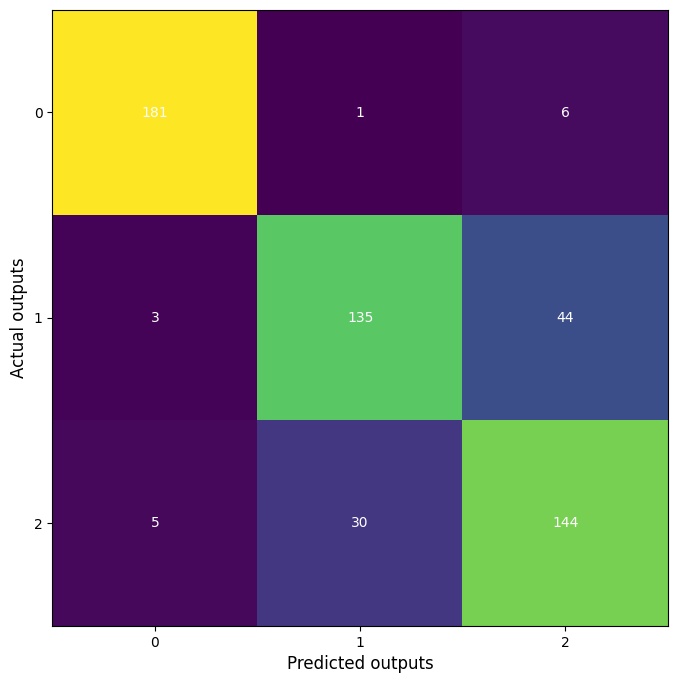

In [20]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

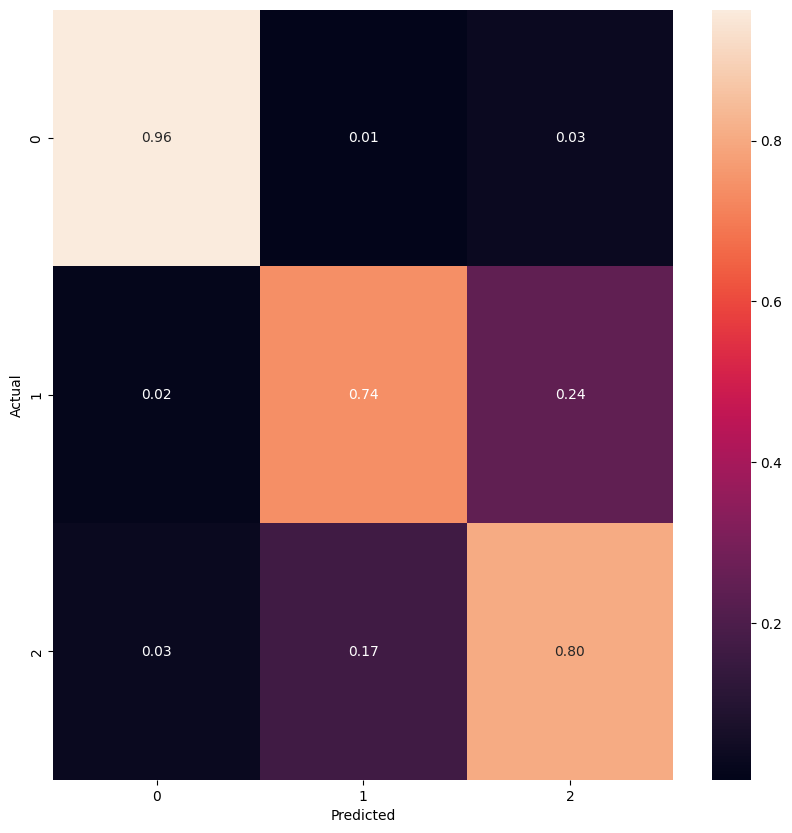

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## bSMOTE with SVM

In [22]:
from imblearn.over_sampling import SVMSMOTE
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
df = df.dropna()

In [23]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

In [24]:
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 13)

In [25]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 90, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [26]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [27]:
clf.score(X_test, y_test)

0.8607594936708861

In [28]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.89      0.98      0.93        86
          CN       0.77      0.87      0.82       187
        EMCI       0.87      0.79      0.83        75
        LMCI       0.98      0.91      0.94        65
         MCI       0.89      0.81      0.85       160
         SMC       0.94      0.83      0.88        59

    accuracy                           0.86       632
   macro avg       0.89      0.86      0.88       632
weighted avg       0.87      0.86      0.86       632



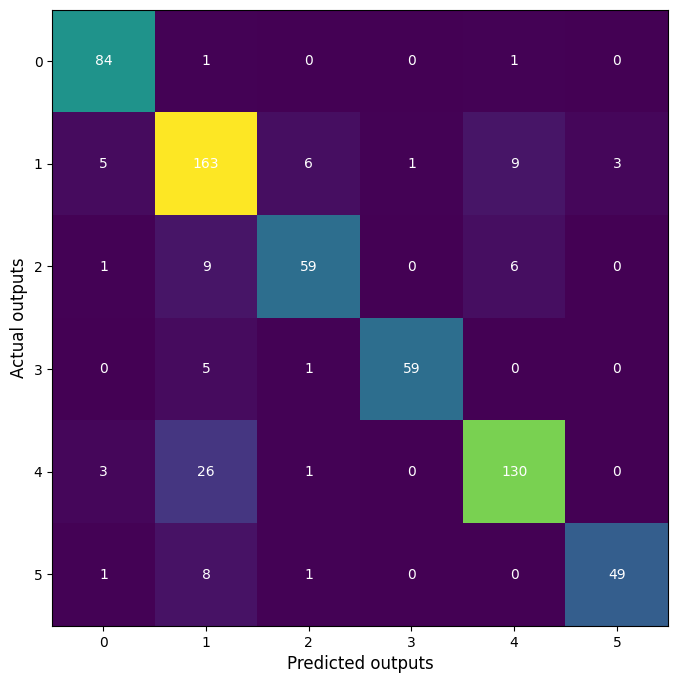

In [29]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

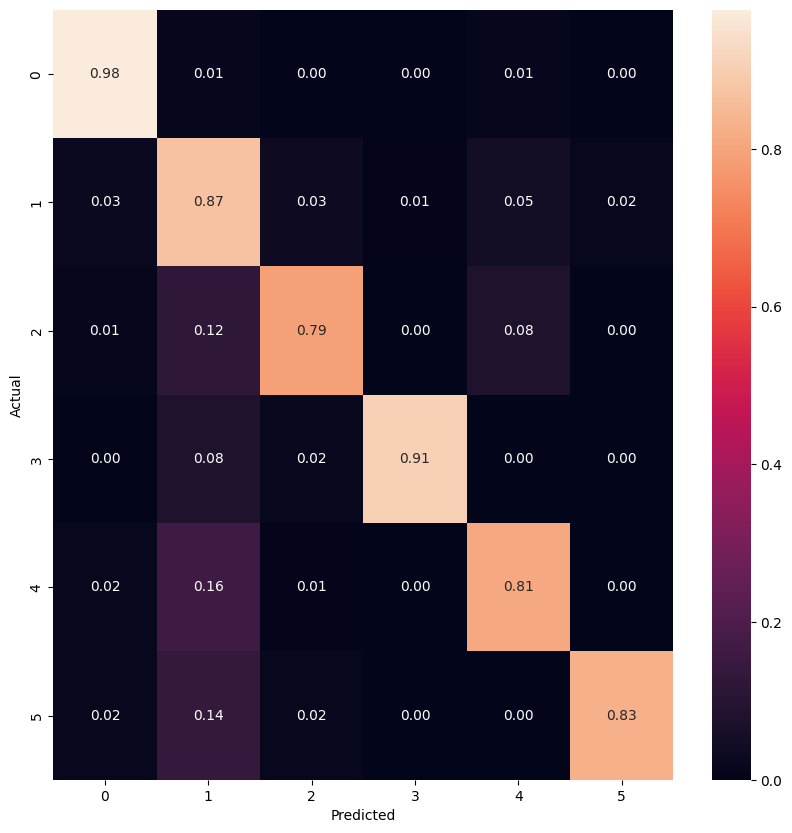

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI Groups

In [31]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
df = df.dropna()

In [32]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

In [33]:
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 15)

In [34]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 91, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [35]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [36]:
clf.score(X_test, y_test)

0.7898230088495575

In [37]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.99      0.89      0.94        83
          CN       0.78      0.74      0.76       192
         MCI       0.73      0.79      0.76       177

    accuracy                           0.79       452
   macro avg       0.83      0.81      0.82       452
weighted avg       0.80      0.79      0.79       452



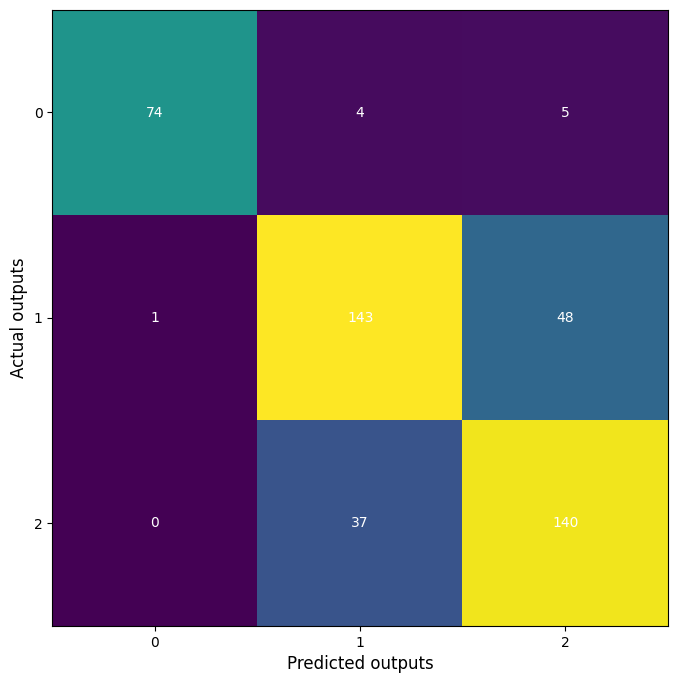

In [38]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

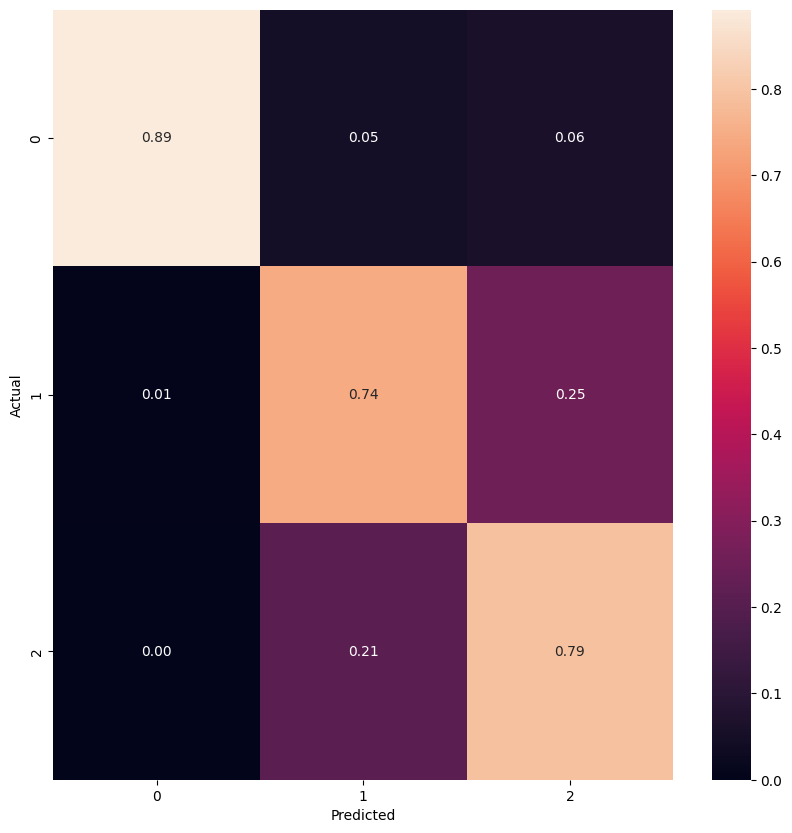

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## SMOTE + ENN

In [40]:
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
df = df.dropna()

In [41]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=4)
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [42]:
X_resampled = StandardScaler().fit_transform(X_resampled)
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 15)

In [43]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 92, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [44]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [45]:
clf.score(X_test, y_test)

0.9759493670886076

In [46]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.98      0.99      0.98       171
          CN       1.00      0.17      0.29         6
        EMCI       0.96      0.99      0.98       134
        LMCI       0.98      0.99      0.99       168
         MCI       0.97      0.94      0.95       155
         SMC       0.99      0.99      0.99       156

    accuracy                           0.98       790
   macro avg       0.98      0.85      0.86       790
weighted avg       0.98      0.98      0.97       790



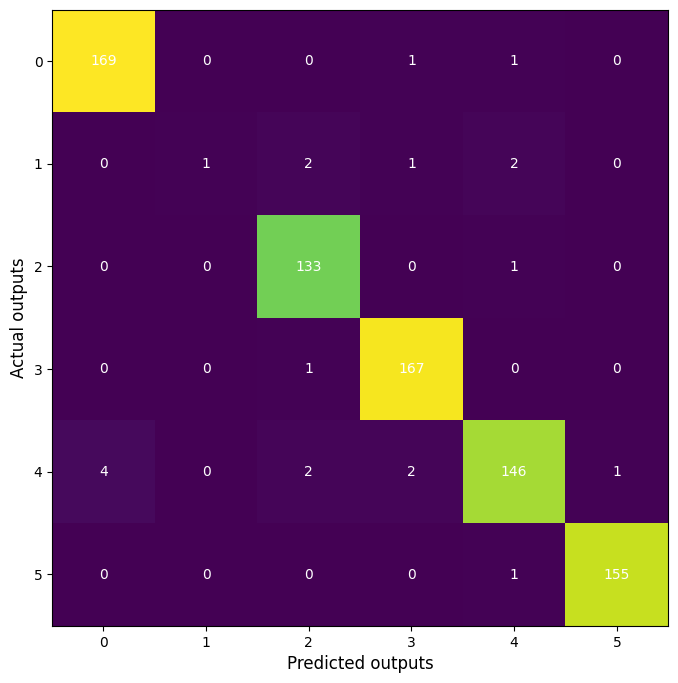

In [47]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

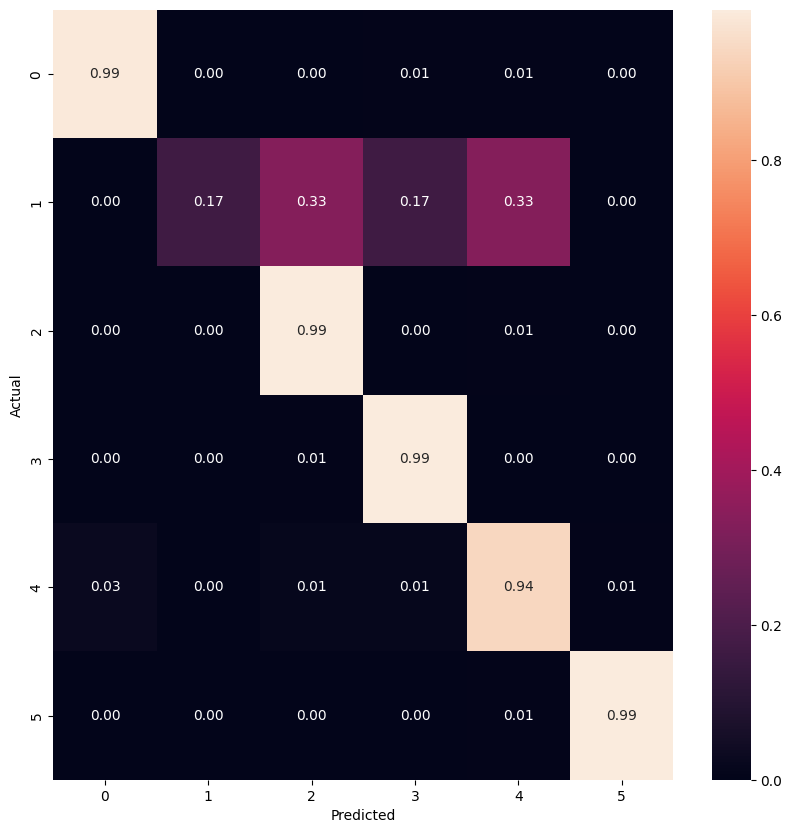

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [49]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
df = df.dropna()

In [50]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=4)
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [51]:
X_resampled = StandardScaler().fit_transform(X_resampled)
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 17)

In [52]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 93, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [53]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [54]:
clf.score(X_test, y_test)

0.8734939759036144

In [55]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.96      0.98      0.97       174
          CN       0.86      0.28      0.42        43
         MCI       0.76      0.93      0.84       115

    accuracy                           0.87       332
   macro avg       0.86      0.73      0.74       332
weighted avg       0.88      0.87      0.85       332



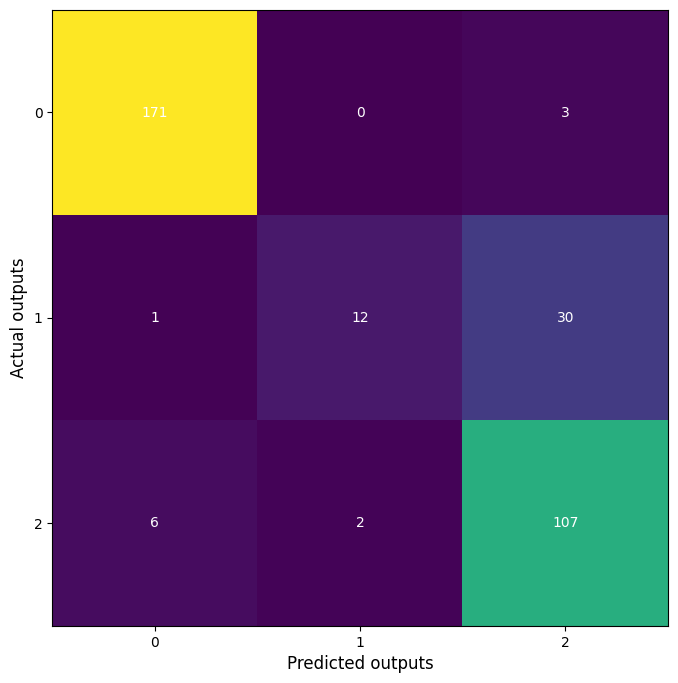

In [56]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

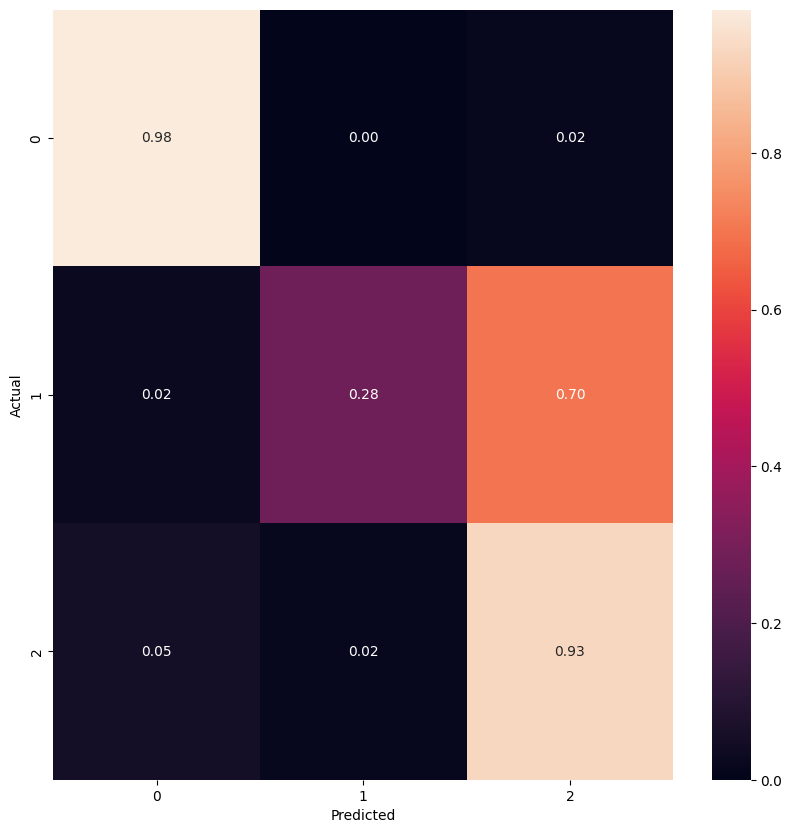

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# k-Nearest Neighbors

## bSMOTE with borderline 1

In [58]:
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [59]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 19)

In [60]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [61]:
pred = classifier.predict(X_test)
classifier.score(X_train, y_train)

0.78199291856348

In [62]:
classifier.score(X_test, y_test)

0.7425641025641025

In [63]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.79      0.99      0.88       158
          CN       0.85      0.13      0.23       171
        EMCI       0.78      0.77      0.77       171
        LMCI       0.72      0.95      0.82       157
         MCI       0.65      0.72      0.68       161
         SMC       0.76      0.94      0.84       157

    accuracy                           0.74       975
   macro avg       0.76      0.75      0.70       975
weighted avg       0.76      0.74      0.70       975



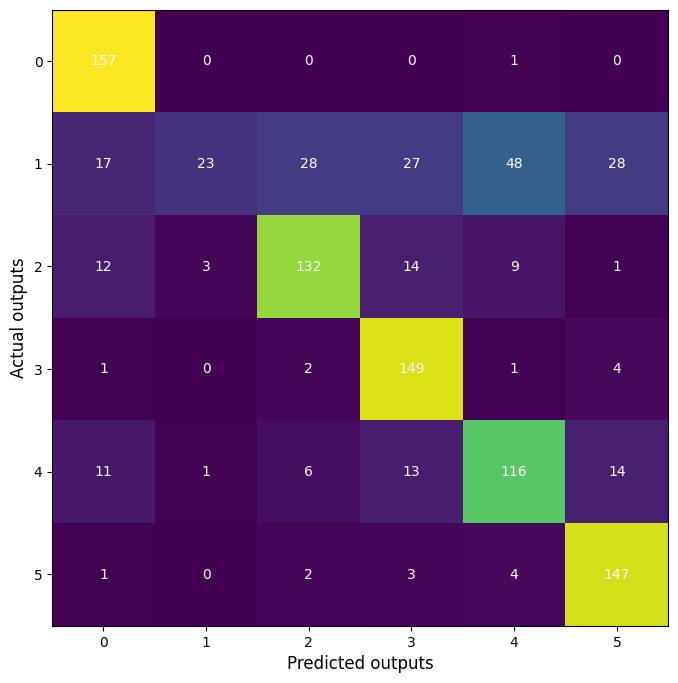

In [64]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

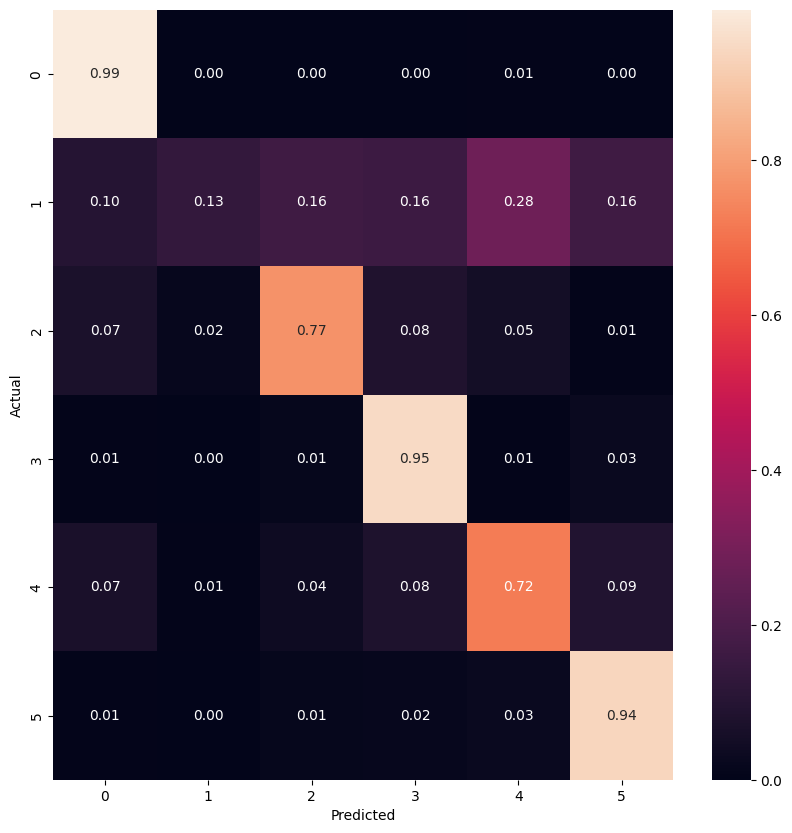

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [66]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [67]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 21)

In [68]:
classifier = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [69]:
pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.6575591985428051

In [70]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.68      0.97      0.80       181
          CN       0.71      0.38      0.50       184
         MCI       0.60      0.62      0.61       184

    accuracy                           0.66       549
   macro avg       0.66      0.66      0.64       549
weighted avg       0.66      0.66      0.64       549



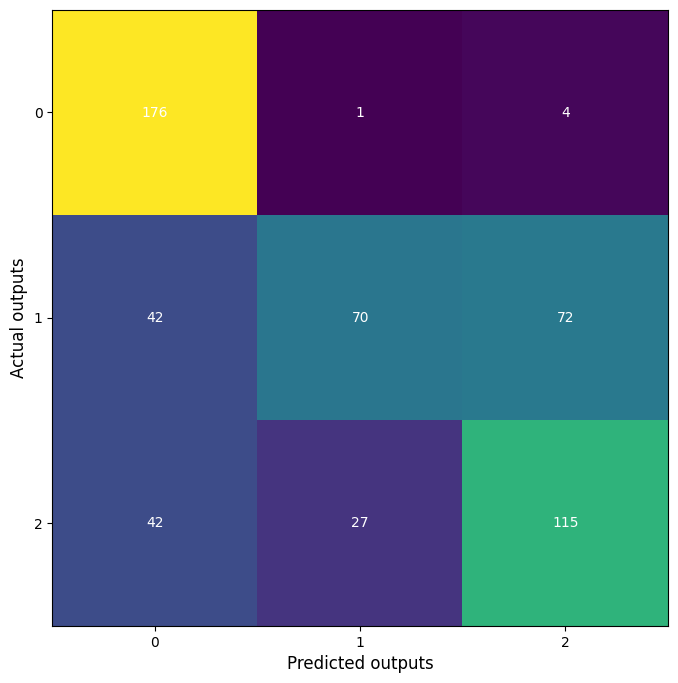

In [71]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

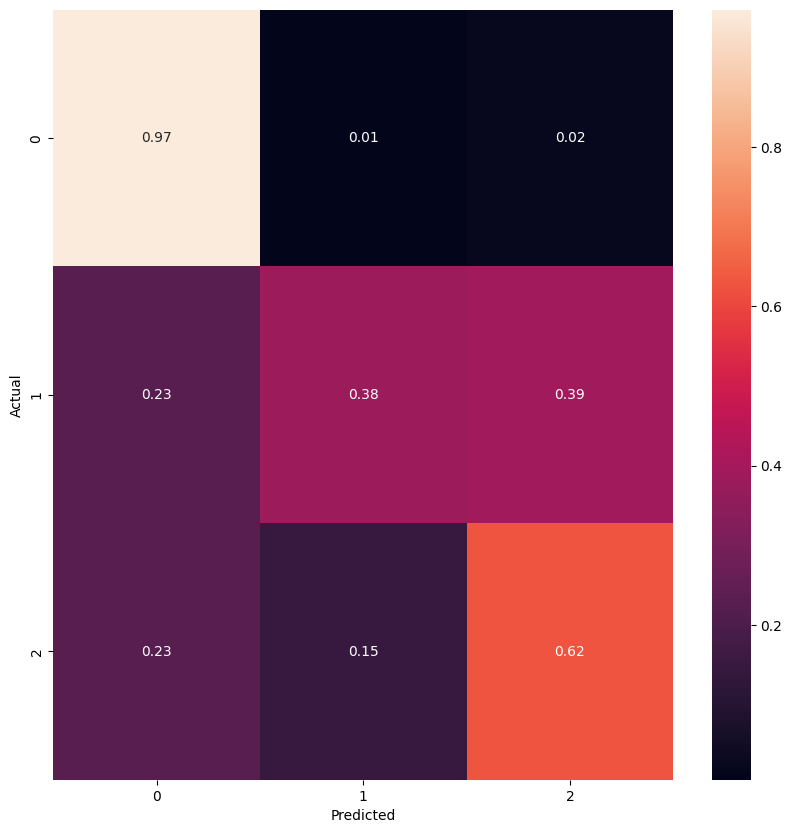

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## bSMOTE with SVM

In [73]:
from imblearn.over_sampling import SVMSMOTE
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [74]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 23)

In [75]:
classifier = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [76]:
pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.6740638002773925

In [77]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.64      0.90      0.75        83
          CN       0.81      0.21      0.33       168
        EMCI       0.66      0.74      0.70        93
        LMCI       0.61      0.99      0.76        91
         MCI       0.77      0.66      0.71       167
         SMC       0.64      0.90      0.75       119

    accuracy                           0.67       721
   macro avg       0.69      0.73      0.67       721
weighted avg       0.71      0.67      0.64       721



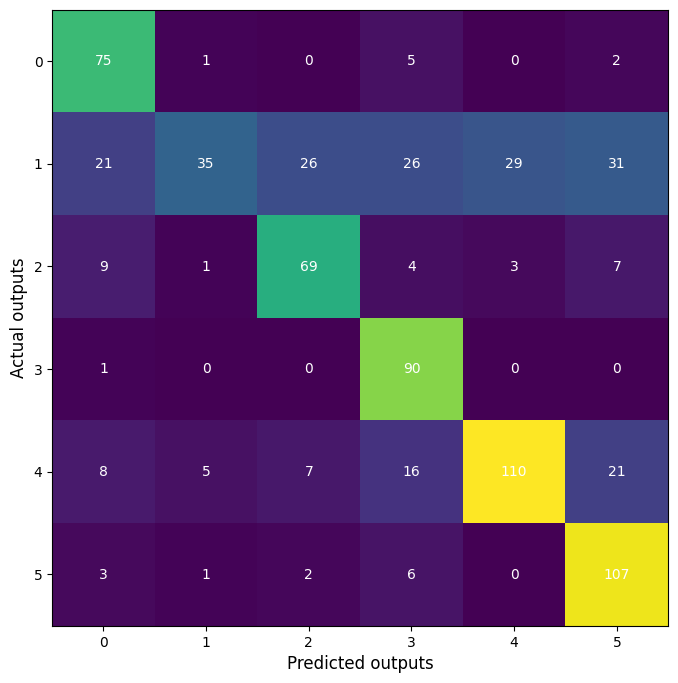

In [78]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

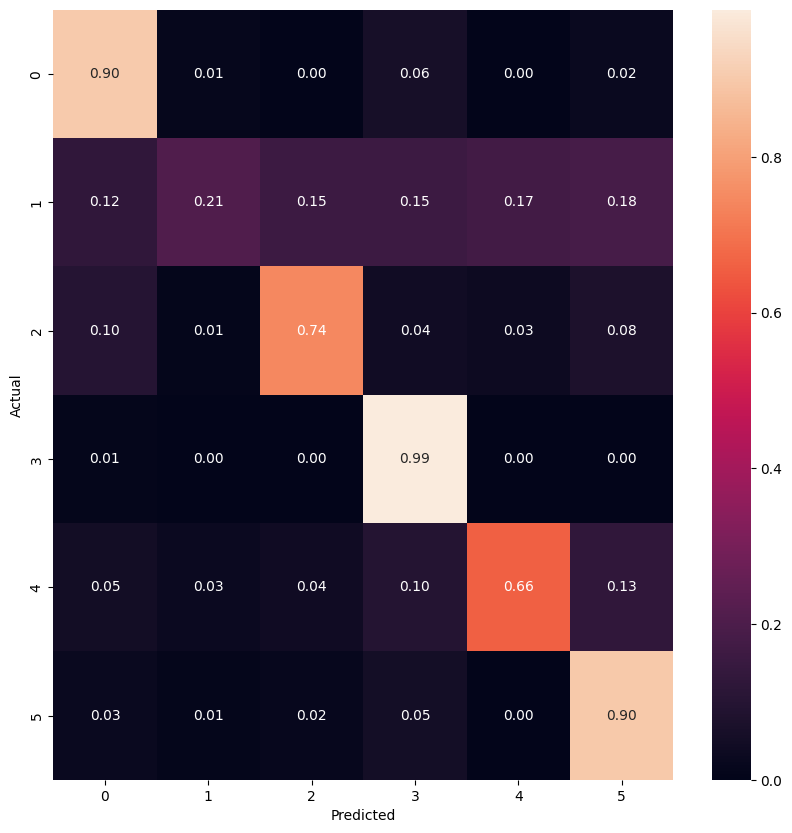

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [80]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [81]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 25)

In [82]:
classifier = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [83]:
pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.5786026200873362

In [84]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.56      0.93      0.70        96
          CN       0.55      0.51      0.53       160
         MCI       0.64      0.47      0.54       202

    accuracy                           0.58       458
   macro avg       0.58      0.63      0.59       458
weighted avg       0.59      0.58      0.57       458



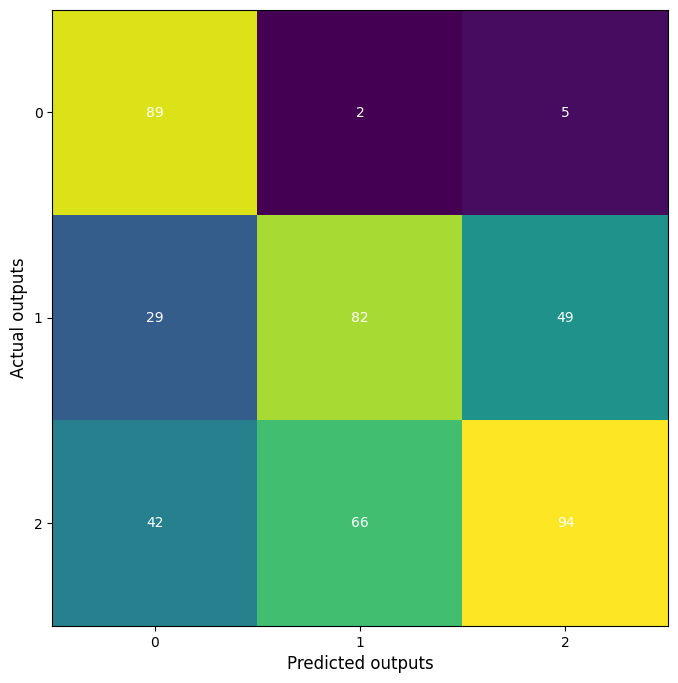

In [85]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

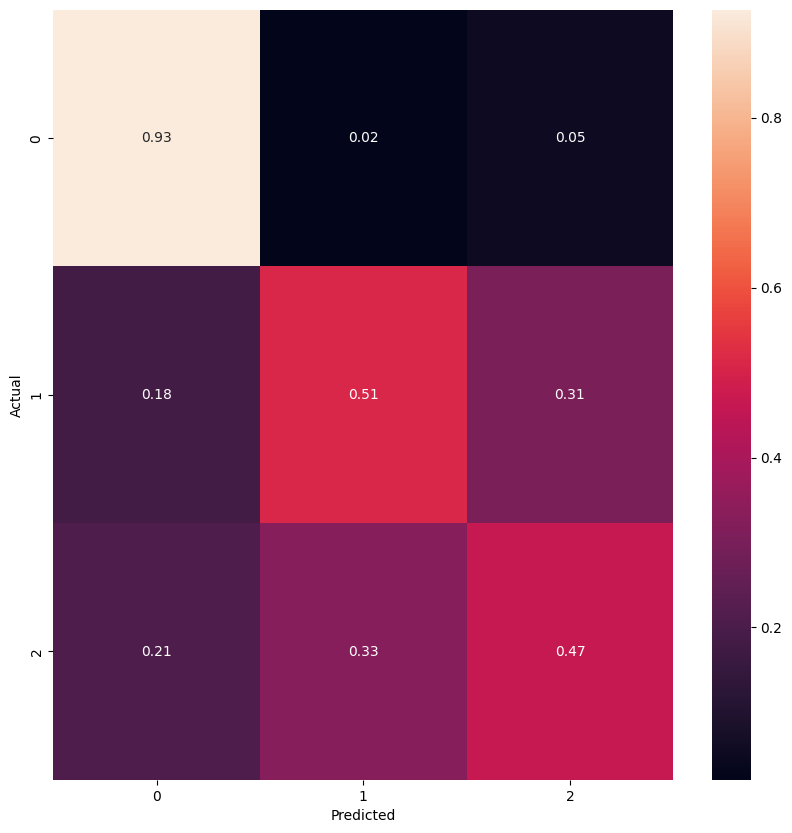

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## SMOTE with ENN

In [87]:
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [88]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=4)
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 27)

In [89]:
classifier = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [90]:
pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.8658227848101265

In [91]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.90      0.93      0.92       181
          CN       0.00      0.00      0.00         9
        EMCI       0.92      0.81      0.86       181
        LMCI       0.81      0.98      0.89       138
         MCI       0.89      0.70      0.78       127
         SMC       0.82      0.94      0.87       154

    accuracy                           0.87       790
   macro avg       0.72      0.73      0.72       790
weighted avg       0.86      0.87      0.86       790



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

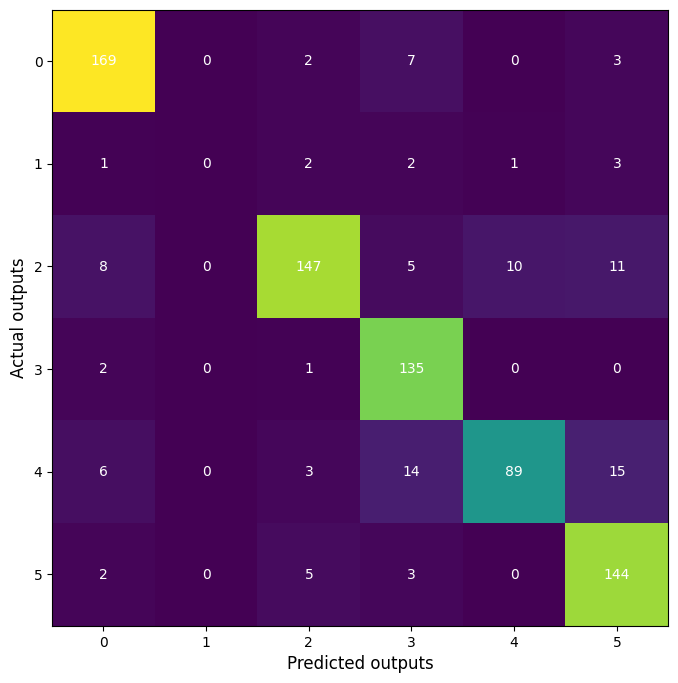

In [92]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

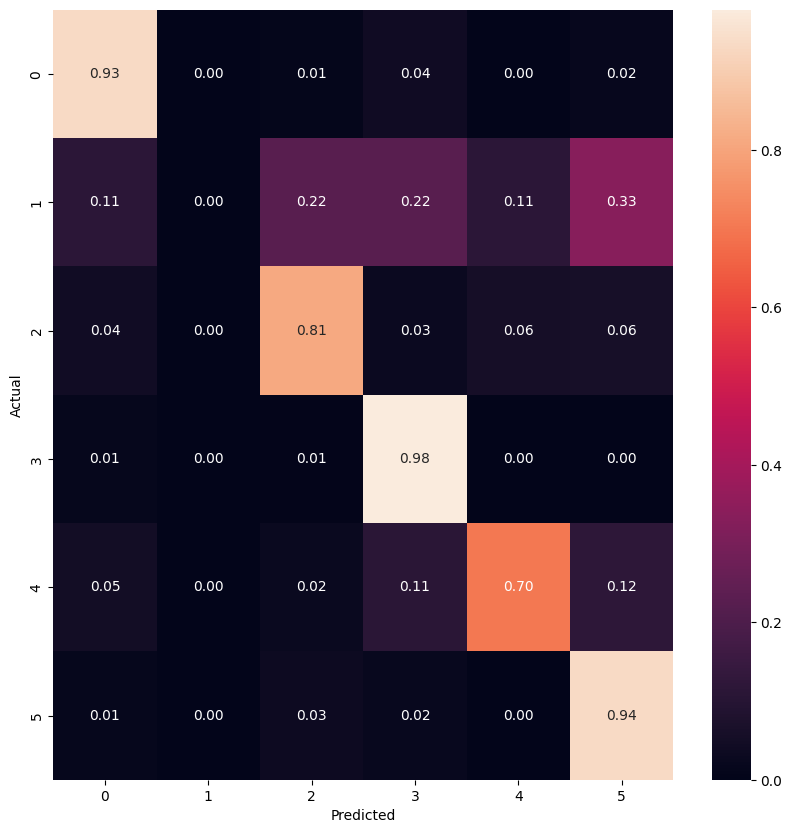

In [93]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [94]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [95]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=4)
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 29)

In [96]:
classifier = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [97]:
pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.7198795180722891

In [98]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.72      0.97      0.82       172
          CN       0.50      0.09      0.15        35
         MCI       0.74      0.55      0.63       125

    accuracy                           0.72       332
   macro avg       0.65      0.54      0.53       332
weighted avg       0.70      0.72      0.68       332



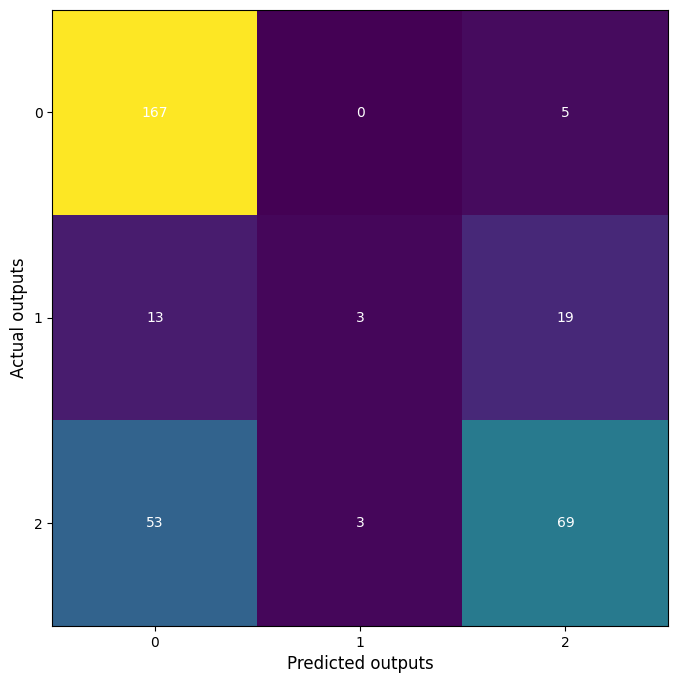

In [99]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

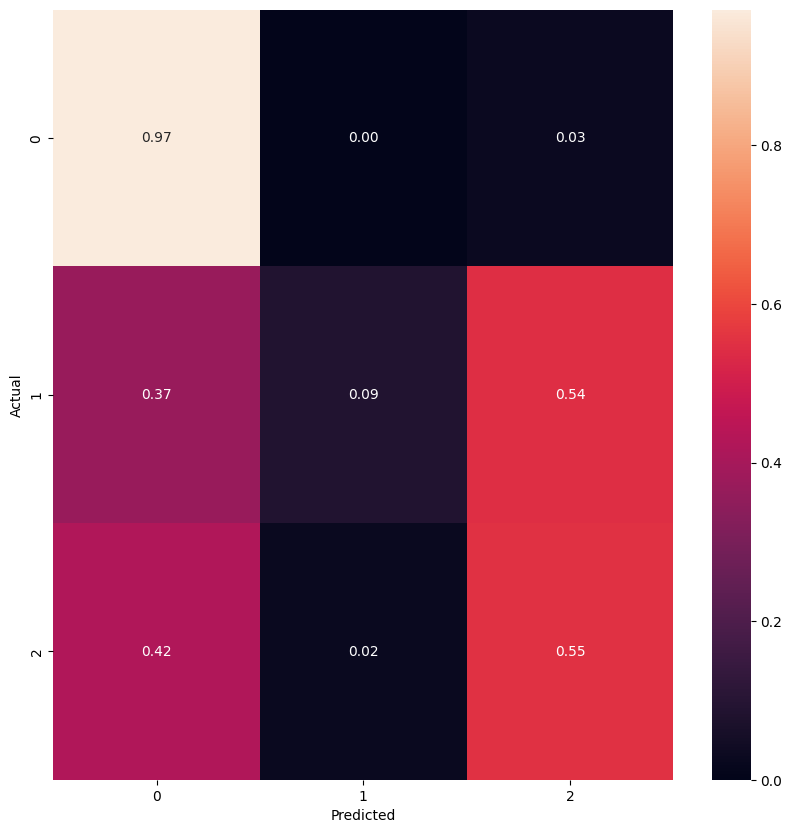

In [100]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Gradient Boosting

## bSMOTE: Borderline-1

In [101]:
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [102]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 31)

In [106]:
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=2000, learning_rate=learning_rate, max_depth=5, random_state=8)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.927
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.922
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.924
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.915
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.922
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.911
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.892


In [107]:
gb_clf2 = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.05, max_depth=5, random_state=8)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[171   4   0   0   1   0]
 [  0 111   5   2  20  11]
 [  2   5 138   0   0   0]
 [  0   0   2 173   1   0]
 [  1  11   3   0 149   2]
 [  0   1   0   0   0 162]]
Classification Report
              precision    recall  f1-score   support

          AD       0.98      0.97      0.98       176
          CN       0.84      0.74      0.79       149
        EMCI       0.93      0.95      0.94       145
        LMCI       0.99      0.98      0.99       176
         MCI       0.87      0.90      0.88       166
         SMC       0.93      0.99      0.96       163

    accuracy                           0.93       975
   macro avg       0.92      0.92      0.92       975
weighted avg       0.93      0.93      0.93       975



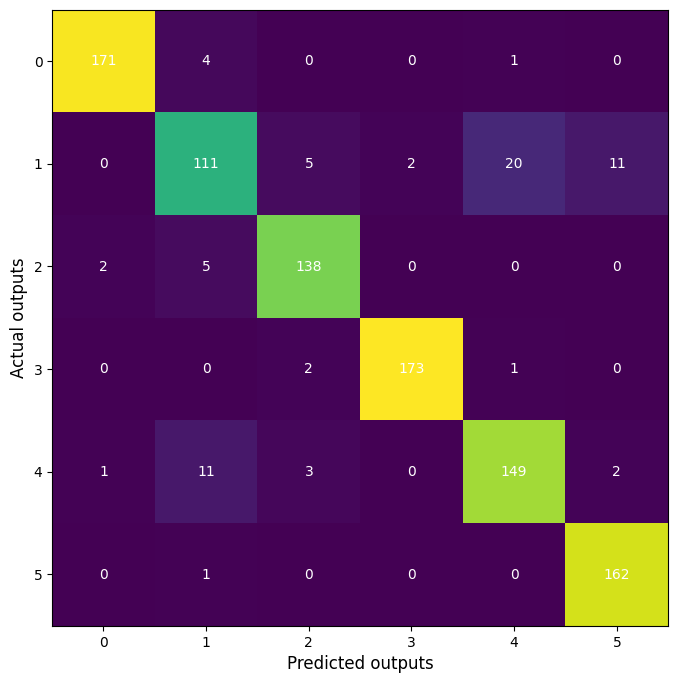

In [109]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

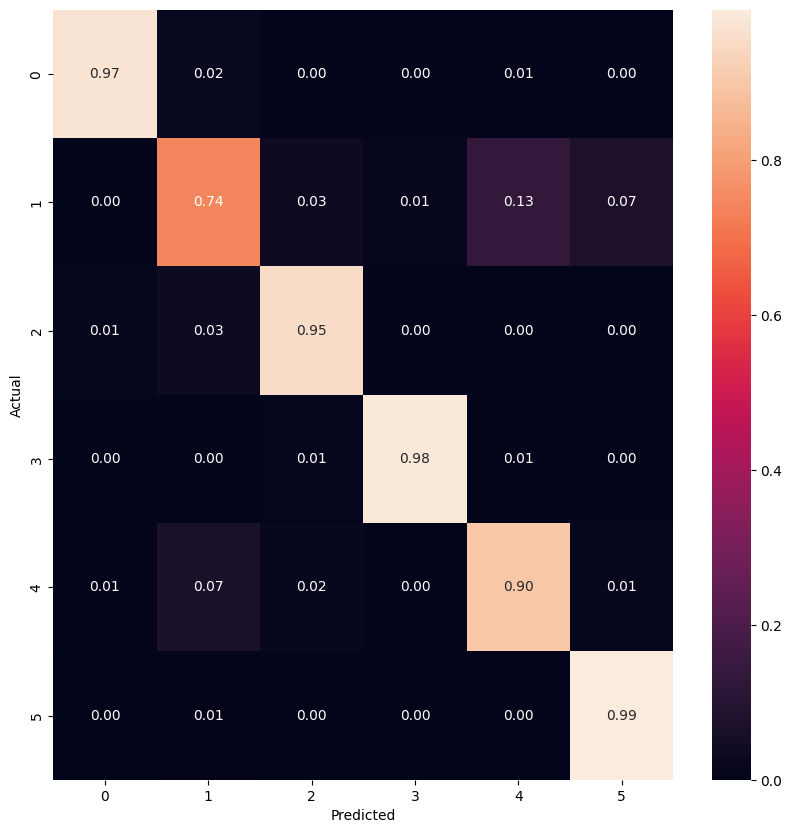

In [110]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [111]:
df = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [112]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 33)

In [113]:
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=2000, learning_rate=learning_rate, max_depth=5, random_state=11)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.825
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.831
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.827
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.840
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.825
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.816
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.842


In [114]:
gb_clf2 = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.05, max_depth=5, random_state=8)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[168   3   2]
 [  1 148  51]
 [  6  32 138]]
Classification Report
              precision    recall  f1-score   support

          AD       0.96      0.97      0.97       173
          CN       0.81      0.74      0.77       200
         MCI       0.72      0.78      0.75       176

    accuracy                           0.83       549
   macro avg       0.83      0.83      0.83       549
weighted avg       0.83      0.83      0.83       549



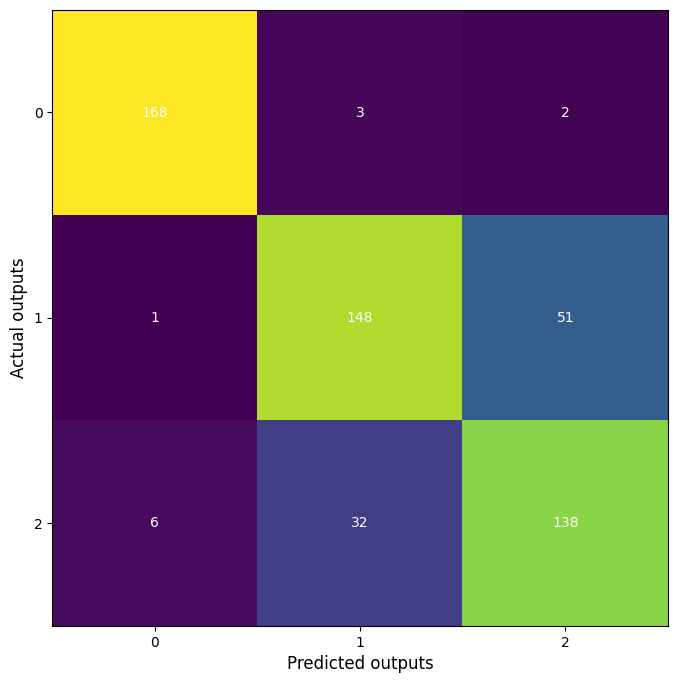

In [115]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

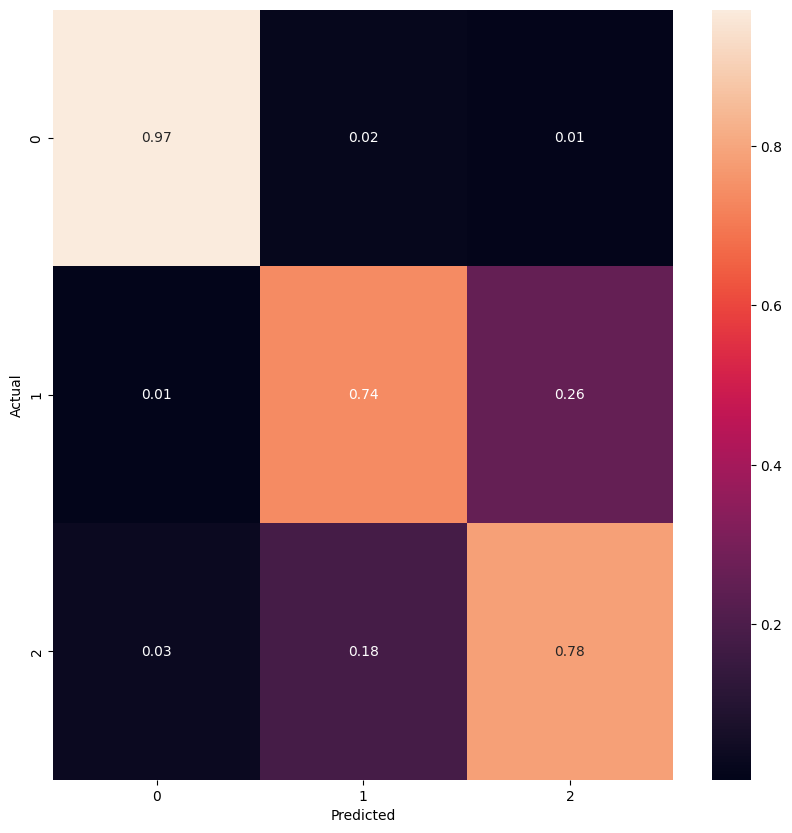

In [116]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## bSMOTE with SVM

In [117]:
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [118]:
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 35)

In [119]:
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=2000, learning_rate=learning_rate, max_depth=5, random_state=11)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.851
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.839
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.849
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.854
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.839
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.839
Learning rate:  1
Accuracy score (training): 0.999
Accuracy score (validation): 0.824


In [120]:
gb_clf2 = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.05, max_depth=5, random_state=23)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[ 75   3   0   1   1   1]
 [  1 133  11   1  18   6]
 [  1   9  72   1   1   0]
 [  2   3   0  90   0   0]
 [  0  20   4   2 134   2]
 [  1   8   0   0   6  56]]
Classification Report
              precision    recall  f1-score   support

          AD       0.94      0.93      0.93        81
          CN       0.76      0.78      0.77       170
        EMCI       0.83      0.86      0.84        84
        LMCI       0.95      0.95      0.95        95
         MCI       0.84      0.83      0.83       162
         SMC       0.86      0.79      0.82        71

    accuracy                           0.84       663
   macro avg       0.86      0.85      0.86       663
weighted avg       0.85      0.84      0.84       663



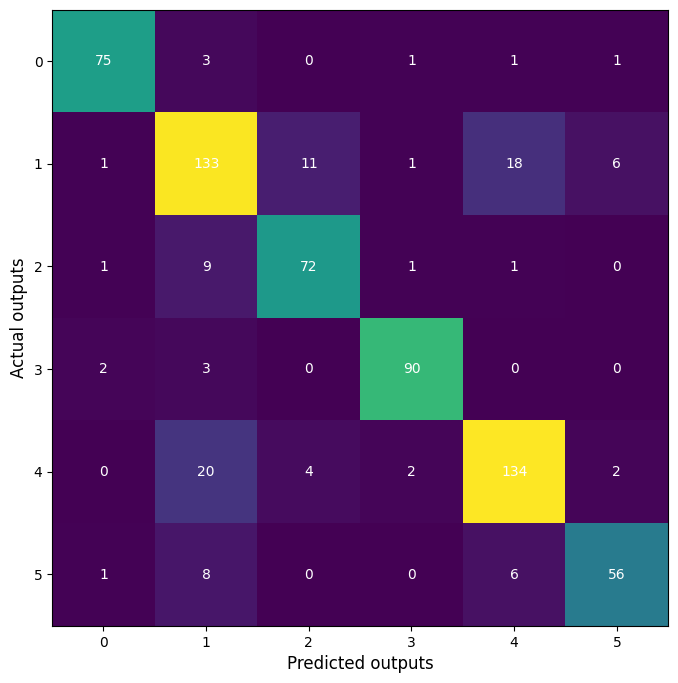

In [121]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

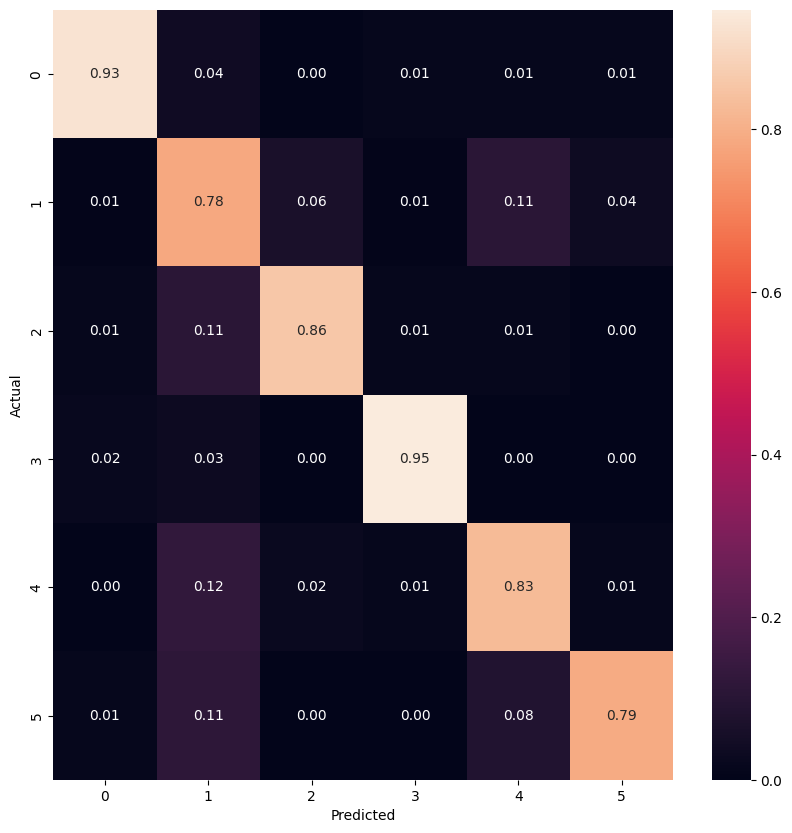

In [122]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## SMOTE + ENN

In [123]:
df = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns + confounding
df = df.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 
                          'VISCODE2', 'EXAMDATE', 'VERSION', 'MANUFACTURER',
                         'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'Age', 'VOLUMES', 'Sex'], axis=1)
# remove rows with empty values
df = df.dropna()

In [124]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=4)
X = df.iloc[:, df.columns != 'Research Group'].values
y = df.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 39)

In [125]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=2000, learning_rate=learning_rate, max_depth=5, random_state=23)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.962
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.957
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.956
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.958
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.957
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.956
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.939


In [126]:
gb_clf2 = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.05, max_depth=5, random_state=39)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[160   0   0   2   0   0]
 [  0   4   1   0   2   0]
 [  1   0 144   2   3   1]
 [  1   0   0 156   0   0]
 [  2   0  11   0 129   4]
 [  0   0   0   0   1 166]]
Classification Report
              precision    recall  f1-score   support

          AD       0.98      0.99      0.98       162
          CN       1.00      0.57      0.73         7
        EMCI       0.92      0.95      0.94       151
        LMCI       0.97      0.99      0.98       157
         MCI       0.96      0.88      0.92       146
         SMC       0.97      0.99      0.98       167

    accuracy                           0.96       790
   macro avg       0.97      0.90      0.92       790
weighted avg       0.96      0.96      0.96       790



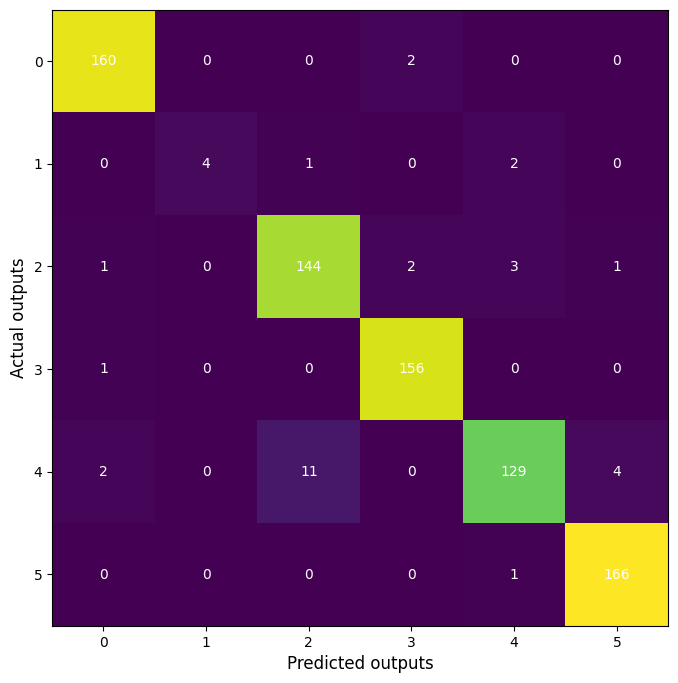

In [127]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

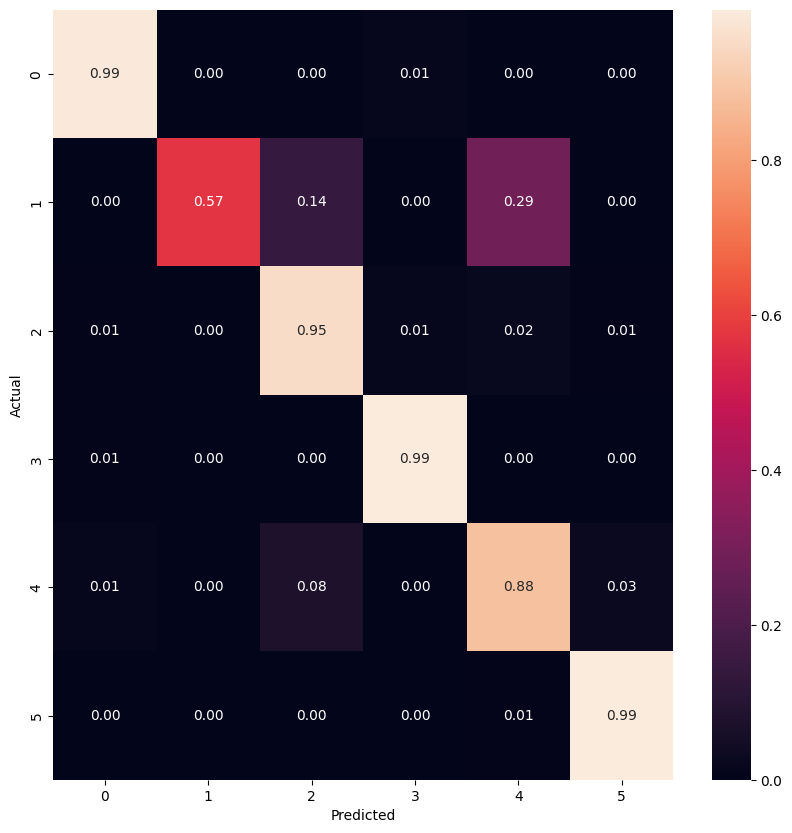

In [128]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)